# Data Association


In [66]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

!pip -q install -r ../requirements.txt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


In [8]:
!wget pollithy.com/Pfeffer.zip
!unzip -q Pfeffer.zip

--2019-12-08 11:29:55--  http://pollithy.com/Pfeffer.zip
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pollithy.com/Pfeffer.zip [following]
--2019-12-08 11:29:55--  https://pollithy.com/Pfeffer.zip
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11741795 (11M) [application/zip]
Saving to: ‘Pfeffer.zip.1’

Pfeffer.zip.1       100%[===================>]  11.20M  10.7MB/s    in 1.0s    

2019-12-08 11:29:56 (10.7 MB/s) - ‘Pfeffer.zip.1’ saved [11741795/11741795]

replace Pfeffer/011.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Pfeffer/004.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [67]:
import os
import random
import itertools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime
from collections import defaultdict

# custom modules
import data
import model

print('Tensorflow version:', tf.__version__)

print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [10, 5]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.0.0
GPU support: True


In [0]:
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment

In [86]:
import importlib
importlib.reload(data)

<module 'data' from '/content/data.py'>

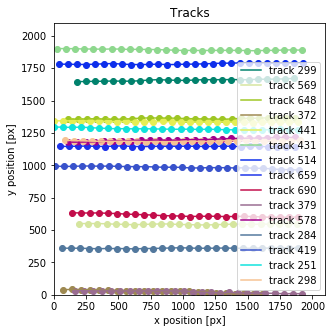

In [92]:
num_time_steps = 350
nan_value = 0
batch_size = 64
belt_width = 2000

dataset = data.FakeDataSet(timesteps=num_time_steps, batch_size=batch_size, number_trajectories=700, 
                           additive_noise_stddev=2, additive_target_stddev=20, belt_width=belt_width,
                          nan_value=nan_value)

# dataset_train, dataset_test = dataset.get_tf_data_sets_seq2seq_data(normalized=True)
dataset_train, dataset_test = dataset.get_tf_data_sets_seq2seq_data(normalized=True)

longest_track_time_steps = dataset.longest_track

dataset.plot_random_tracks(n=15)

In [93]:
longest_track_time_steps

28

In [89]:
# Train model
rnn_model, hash_ = model.rnn_model_factory(
		num_units_first_rnn=1024, 
		num_units_second_rnn=16,
		num_units_first_dense=0,
		rnn_model_name='lstm',
		num_time_steps=longest_track_time_steps, 
		batch_size=batch_size, 
		nan_value=nan_value, 
    unroll=True,
		input_dim=2)
print(rnn_model.summary())

optimizer = tf.keras.optimizers.Adam()
train_step_fn = model.train_step_generator(rnn_model, optimizer)

total_num_epochs = 1000

for epoch in range(total_num_epochs):
	# learning rate decay after 100 epochs
	if (epoch+1) % 150 == 0:
		old_lr = K.get_value(optimizer.lr)
		new_lr = old_lr * 0.1
		print("Reducing learning rate from {} to {}.".format(old_lr, new_lr))
		K.set_value(optimizer.lr, new_lr)

	for (batch_n, (inp, target)) in enumerate(dataset_train):
		_ = rnn_model.reset_states()
		loss = train_step_fn(inp, target)	

	print("{}/{}: \t loss={}".format(epoch, total_num_epochs, loss))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (64, 28, 2)               0         
_________________________________________________________________
rnn-0 (LSTM)                 (64, 28, 1024)            4206592   
_________________________________________________________________
rnn-1 (LSTM)                 (64, 28, 16)              66624     
_________________________________________________________________
dense_7 (Dense)              (64, 28, 2)               34        
Total params: 4,273,250
Trainable params: 4,273,250
Non-trainable params: 0
_________________________________________________________________
None
0/1000: 	 loss=0.0050897766675709775
1/1000: 	 loss=0.002634581154950509
2/1000: 	 loss=0.0016384217268642703
3/1000: 	 loss=0.0005762113468831324
4/1000: 	 loss=0.0002651784587042629
5/1000: 	 loss=0.0001749078111156013
6/1000: 	 loss=0

KeyboardInterrupt: ignored

Distances
[[0.1   0.435]
 [0.428 0.063]]


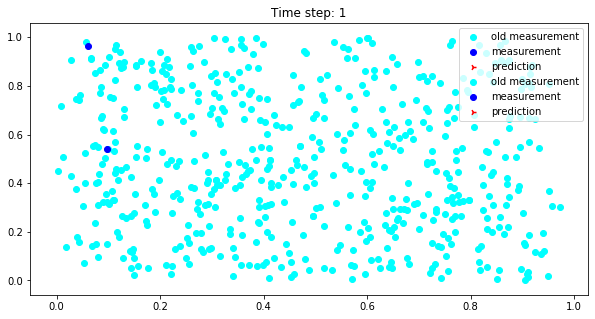

Distances
[[0.001 0.421 0.209 0.387 0.445]
 [0.184 0.265 0.044 0.208 0.267]
 [0.383 0.103 0.203 0.011 0.062]
 [0.425 0.005 0.281 0.115 0.098]]


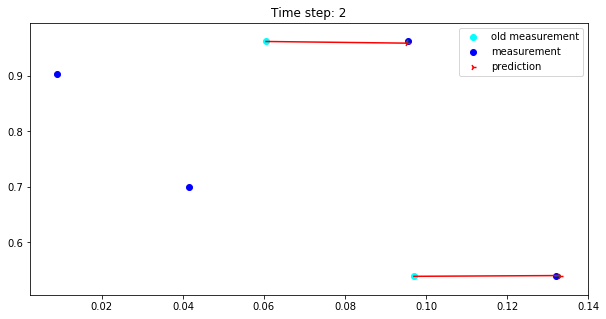

Distances
[[0.161 0.461 0.196 0.386 0.011 0.181 0.136 0.384 0.471]
 [0.002 0.426 0.187 0.385 0.171 0.233 0.23  0.401 0.52 ]
 [0.183 0.269 0.003 0.207 0.197 0.079 0.326 0.218 0.657]
 [0.198 0.586 0.321 0.52  0.144 0.32  0.05  0.521 0.339]
 [0.382 0.106 0.202 0.002 0.386 0.208 0.521 0.046 0.856]
 [0.427 0.002 0.269 0.108 0.467 0.298 0.598 0.147 0.928]
 [0.508 0.92  0.656 0.856 0.474 0.654 0.339 0.856 0.05 ]]


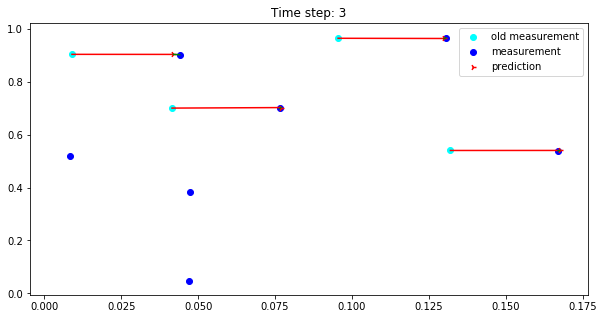

Distances
[[0.161 0.466 0.196 0.389 0.004 0.139 0.467 0.046 0.194 0.14  0.388 0.47 ]
 [0.258 0.308 0.109 0.213 0.189 0.331 0.659 0.188 0.005 0.32  0.197 0.656]
 [0.001 0.427 0.183 0.383 0.161 0.198 0.504 0.206 0.262 0.257 0.415 0.533]
 [0.183 0.272 0.002 0.207 0.192 0.317 0.649 0.215 0.114 0.334 0.233 0.66 ]
 [0.196 0.587 0.317 0.519 0.141 0.001 0.334 0.157 0.331 0.085 0.524 0.346]
 [0.382 0.107 0.204 0.002 0.383 0.519 0.851 0.394 0.213 0.523 0.081 0.857]
 [0.428 0.001 0.272 0.107 0.463 0.589 0.92  0.481 0.311 0.606 0.18  0.933]
 [0.506 0.921 0.652 0.855 0.473 0.334 0.002 0.475 0.661 0.346 0.857 0.084]]


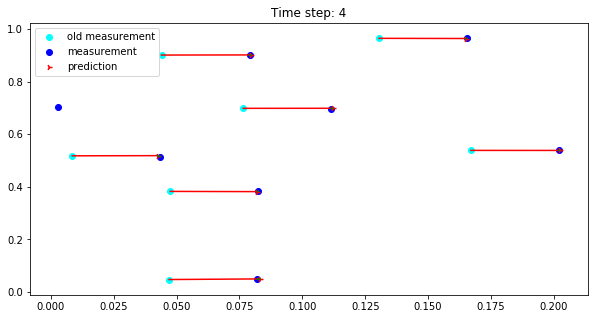

Distances
[[0.16  0.467 0.196 0.388 0.001 0.137 0.468 0.195 0.081 0.206 0.245]
 [0.258 0.307 0.109 0.211 0.193 0.331 0.661 0.002 0.194 0.04  0.058]
 [0.002 0.429 0.183 0.383 0.161 0.196 0.505 0.261 0.241 0.291 0.317]
 [0.181 0.274 0.001 0.207 0.194 0.315 0.649 0.11  0.235 0.149 0.157]
 [0.197 0.588 0.316 0.518 0.138 0.    0.335 0.332 0.178 0.343 0.382]
 [0.381 0.108 0.205 0.001 0.387 0.517 0.852 0.21  0.403 0.228 0.194]
 [0.427 0.    0.273 0.108 0.467 0.588 0.921 0.308 0.495 0.331 0.299]
 [0.276 0.265 0.105 0.167 0.232 0.368 0.7   0.043 0.237 0.069 0.056]
 [0.506 0.921 0.65  0.853 0.468 0.335 0.001 0.662 0.481 0.667 0.707]]


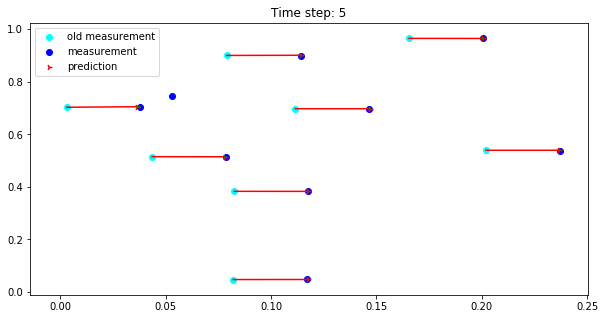

Distances
[[0.16  0.467 0.194 0.387 0.    0.137 0.468 0.194 0.234 0.119 0.222 0.317
  0.328 0.258]
 [0.265 0.48  0.233 0.385 0.109 0.215 0.515 0.174 0.22  0.01  0.162 0.323
  0.335 0.203]
 [0.259 0.307 0.109 0.21  0.194 0.331 0.661 0.    0.046 0.179 0.075 0.491
  0.502 0.086]
 [0.001 0.428 0.181 0.381 0.161 0.196 0.505 0.259 0.277 0.275 0.32  0.421
  0.43  0.343]
 [0.385 0.767 0.493 0.687 0.3   0.19  0.197 0.485 0.529 0.328 0.488 0.058
  0.059 0.529]
 [0.18  0.277 0.003 0.209 0.192 0.312 0.647 0.109 0.107 0.238 0.184 0.509
  0.519 0.191]
 [0.195 0.587 0.314 0.516 0.136 0.001 0.336 0.33  0.369 0.222 0.356 0.226
  0.235 0.393]
 [0.382 0.109 0.206 0.001 0.387 0.516 0.852 0.21  0.164 0.388 0.247 0.697
  0.708 0.216]
 [0.431 0.002 0.276 0.109 0.469 0.59  0.923 0.309 0.264 0.487 0.355 0.785
  0.796 0.325]
 [0.379 0.772 0.498 0.695 0.307 0.187 0.173 0.496 0.539 0.346 0.504 0.09
  0.089 0.545]
 [0.277 0.265 0.106 0.166 0.232 0.368 0.701 0.044 0.002 0.222 0.099 0.534
  0.545 0.09 ]
 [0.505 0.92

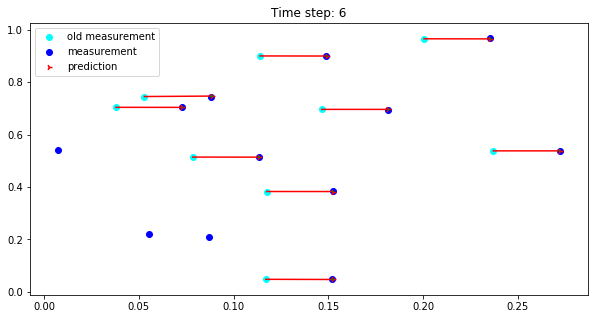

Distances
[[0.16  0.469 0.193 0.387 0.    0.136 0.468 0.195 0.233 0.111 0.302 0.309
  0.154 0.334 0.527 0.214 0.528]
 [0.264 0.482 0.231 0.384 0.11  0.215 0.515 0.175 0.219 0.002 0.328 0.345
  0.045 0.329 0.535 0.186 0.536]
 [0.259 0.308 0.109 0.208 0.195 0.331 0.662 0.001 0.043 0.175 0.488 0.499
  0.197 0.501 0.705 0.36  0.706]
 [0.    0.429 0.18  0.381 0.161 0.196 0.506 0.259 0.276 0.266 0.388 0.382
  0.31  0.447 0.614 0.357 0.615]
 [0.388 0.772 0.494 0.69  0.303 0.194 0.194 0.488 0.53  0.331 0.001 0.031
  0.339 0.093 0.227 0.173 0.228]
 [0.177 0.281 0.003 0.211 0.189 0.308 0.644 0.109 0.108 0.229 0.49  0.494
  0.265 0.523 0.716 0.395 0.717]
 [0.599 0.988 0.711 0.904 0.519 0.407 0.163 0.7   0.743 0.535 0.218 0.218
  0.534 0.21  0.032 0.355 0.032]
 [0.195 0.589 0.311 0.515 0.136 0.    0.337 0.33  0.367 0.216 0.193 0.19
  0.247 0.254 0.421 0.191 0.421]
 [0.281 0.631 0.356 0.546 0.163 0.101 0.329 0.343 0.385 0.188 0.145 0.159
  0.202 0.172 0.365 0.091 0.366]
 [0.38  0.11  0.207 0.001 0.

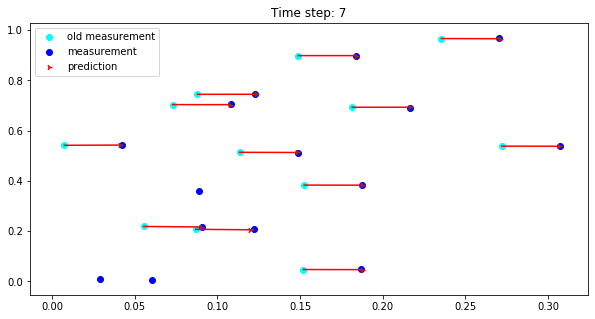

Distances
[[0.16  0.472 0.191 0.388 0.001 0.134 0.465 0.196 0.235 0.11  0.302 0.306
  0.512 0.162 0.506 0.188 0.421 0.537 0.537]
 [0.264 0.484 0.23  0.385 0.109 0.214 0.513 0.176 0.22  0.001 0.328 0.342
  0.527 0.185 0.527 0.08  0.413 0.538 0.538]
 [0.26  0.308 0.109 0.207 0.197 0.332 0.662 0.002 0.042 0.177 0.49  0.499
  0.696 0.345 0.694 0.22  0.589 0.712 0.713]
 [0.001 0.43  0.177 0.38  0.161 0.196 0.506 0.258 0.276 0.265 0.389 0.38
  0.593 0.282 0.581 0.344 0.531 0.633 0.633]
 [0.388 0.773 0.492 0.689 0.303 0.194 0.193 0.488 0.53  0.329 0.    0.033
  0.21  0.145 0.204 0.349 0.151 0.243 0.244]
 [0.176 0.283 0.001 0.211 0.189 0.307 0.642 0.109 0.108 0.229 0.49  0.492
  0.701 0.353 0.694 0.295 0.61  0.727 0.727]
 [0.511 0.878 0.599 0.787 0.408 0.315 0.211 0.58  0.624 0.409 0.126 0.147
  0.127 0.245 0.138 0.407 0.032 0.13  0.131]
 [0.598 0.989 0.708 0.903 0.518 0.407 0.163 0.7   0.743 0.533 0.216 0.219
  0.006 0.357 0.032 0.536 0.143 0.066 0.067]
 [0.194 0.588 0.306 0.512 0.133 0.002 0

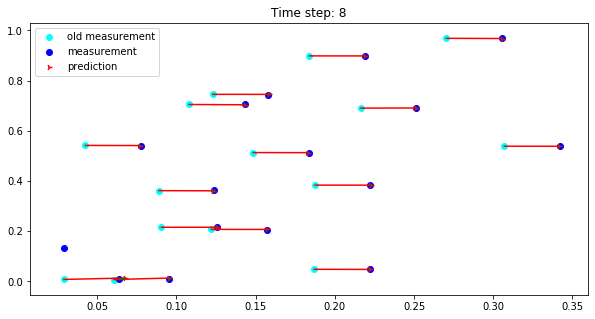

Distances
[[0.331 0.444 0.238 0.335 0.197 0.313 0.611 0.144 0.18  0.102 0.423 0.44
  0.618 0.282 0.622 0.493 0.06  0.494 0.62 ]
 [0.161 0.473 0.192 0.389 0.002 0.131 0.463 0.199 0.236 0.11  0.3   0.304
  0.514 0.159 0.509 0.407 0.25  0.435 0.548]
 [0.264 0.484 0.229 0.384 0.109 0.213 0.513 0.177 0.219 0.001 0.328 0.343
  0.531 0.184 0.532 0.41  0.143 0.421 0.544]
 [0.26  0.308 0.11  0.206 0.198 0.331 0.662 0.001 0.041 0.179 0.49  0.499
  0.701 0.344 0.699 0.584 0.197 0.598 0.72 ]
 [0.001 0.429 0.176 0.379 0.161 0.195 0.505 0.259 0.275 0.265 0.389 0.381
  0.598 0.281 0.585 0.512 0.389 0.554 0.652]
 [0.39  0.775 0.492 0.69  0.303 0.197 0.191 0.491 0.531 0.329 0.002 0.032
  0.213 0.149 0.207 0.125 0.443 0.181 0.262]
 [0.174 0.285 0.002 0.213 0.189 0.304 0.64  0.11  0.109 0.228 0.488 0.49
  0.703 0.349 0.696 0.597 0.295 0.623 0.737]
 [0.51  0.877 0.597 0.786 0.407 0.316 0.211 0.58  0.622 0.407 0.125 0.146
  0.131 0.246 0.143 0.003 0.495 0.066 0.143]
 [0.598 0.988 0.706 0.902 0.517 0.408 0.

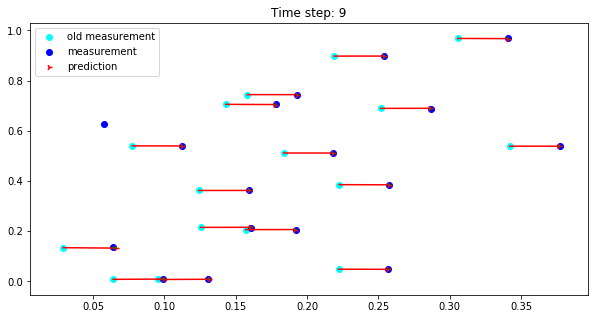

Distances
[[0.331 0.445 0.237 0.335 0.198 0.313 0.609 0.144 0.18  0.102 0.424 0.44
  0.618 0.28  0.622 0.49  0.003 0.095 0.149 0.613 0.198 0.497 0.173]
 [0.161 0.474 0.191 0.389 0.    0.131 0.462 0.2   0.236 0.11  0.301 0.304
  0.515 0.157 0.51  0.405 0.199 0.281 0.256 0.553 0.262 0.452 0.365]
 [0.264 0.485 0.228 0.384 0.11  0.213 0.511 0.177 0.219 0.001 0.329 0.343
  0.532 0.182 0.533 0.408 0.103 0.173 0.153 0.542 0.174 0.43  0.275]
 [0.325 0.541 0.293 0.436 0.165 0.24  0.503 0.231 0.272 0.066 0.314 0.333
  0.504 0.18  0.509 0.375 0.118 0.147 0.091 0.499 0.108 0.384 0.275]
 [0.259 0.309 0.11  0.206 0.199 0.33  0.66  0.    0.042 0.178 0.491 0.499
  0.701 0.342 0.7   0.582 0.143 0.23  0.291 0.719 0.333 0.608 0.225]
 [0.001 0.431 0.175 0.38  0.161 0.194 0.503 0.26  0.276 0.265 0.389 0.379
  0.597 0.279 0.585 0.51  0.331 0.424 0.415 0.664 0.423 0.576 0.475]
 [0.642 1.008 0.727 0.913 0.537 0.447 0.259 0.708 0.75  0.532 0.253 0.268
  0.101 0.38  0.132 0.132 0.611 0.607 0.492 0.037 0.434 0.1

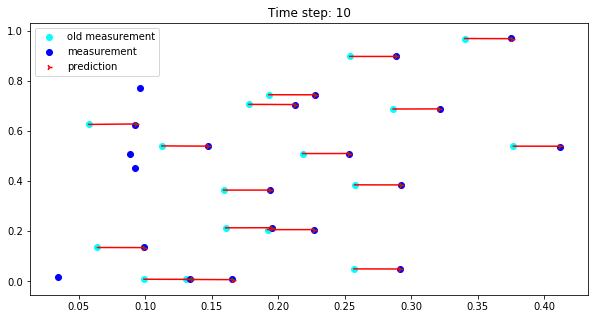

Distances
[[0.331 0.445 0.237 0.335 0.198 0.313 0.609 0.144 0.18  0.102 0.425 0.44
  0.618 0.28  0.623 0.489 0.001 0.114 0.604 0.173 0.146 0.249 0.619 0.141]
 [0.161 0.477 0.191 0.391 0.002 0.13  0.46  0.201 0.238 0.111 0.3   0.303
  0.513 0.155 0.508 0.402 0.199 0.164 0.53  0.17  0.306 0.306 0.567 0.338]
 [0.264 0.484 0.227 0.383 0.111 0.214 0.512 0.176 0.219 0.002 0.331 0.344
  0.533 0.183 0.535 0.407 0.1   0.066 0.529 0.105 0.235 0.225 0.553 0.231]
 [0.374 0.639 0.379 0.536 0.217 0.236 0.432 0.33  0.372 0.154 0.242 0.267
  0.412 0.143 0.42  0.28  0.215 0.102 0.39  0.051 0.36  0.097 0.404 0.282]
 [0.324 0.541 0.292 0.436 0.165 0.24  0.503 0.231 0.273 0.066 0.315 0.334
  0.503 0.18  0.509 0.373 0.115 0.001 0.489 0.058 0.261 0.159 0.505 0.211]
 [0.26  0.309 0.11  0.206 0.201 0.332 0.661 0.001 0.041 0.179 0.493 0.5
  0.702 0.342 0.701 0.581 0.145 0.231 0.705 0.281 0.132 0.385 0.73  0.252]
 [0.001 0.433 0.175 0.381 0.161 0.194 0.502 0.261 0.277 0.265 0.389 0.379
  0.597 0.278 0.584 0.508

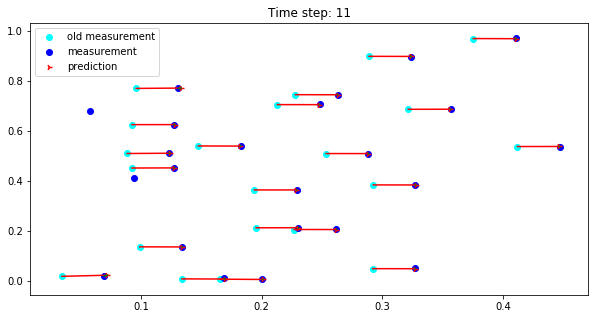

Distances
[[0.332 0.445 0.236 0.333 0.2   0.314 0.61  0.144 0.179 0.102 0.427 0.441
  0.618 0.282 0.625 0.489 0.002 0.117 0.608 0.175 0.143 0.216 0.088 0.526
  0.173]
 [0.161 0.479 0.192 0.391 0.001 0.127 0.458 0.204 0.239 0.112 0.3   0.301
  0.51  0.154 0.508 0.4   0.199 0.164 0.532 0.169 0.307 0.216 0.289 0.5
  0.369]
 [0.264 0.487 0.228 0.384 0.11  0.211 0.509 0.179 0.22  0.002 0.33  0.341
  0.528 0.181 0.533 0.404 0.102 0.065 0.529 0.102 0.237 0.154 0.189 0.467
  0.261]
 [0.374 0.639 0.378 0.534 0.216 0.235 0.432 0.33  0.371 0.154 0.243 0.267
  0.41  0.144 0.422 0.279 0.214 0.101 0.393 0.051 0.358 0.001 0.269 0.316
  0.295]
 [0.325 0.543 0.293 0.436 0.165 0.238 0.501 0.233 0.274 0.067 0.315 0.332
  0.5   0.179 0.508 0.371 0.117 0.002 0.49  0.057 0.261 0.1   0.184 0.414
  0.234]
 [0.261 0.309 0.11  0.204 0.202 0.331 0.661 0.001 0.04  0.178 0.494 0.5
  0.7   0.343 0.702 0.58  0.145 0.232 0.708 0.281 0.133 0.331 0.191 0.646
  0.287]
 [0.001 0.434 0.175 0.38  0.161 0.193 0.5   0.262 0.

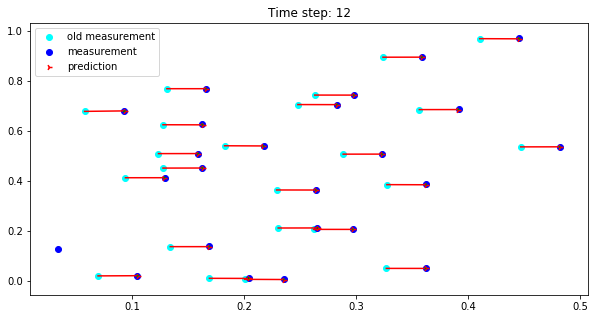

Distances
[[0.332 0.446 0.237 0.334 0.2   0.311 0.609 0.145 0.179 0.103 0.426 0.44
  0.615 0.28  0.624 0.487 0.001 0.117 0.609 0.172 0.143 0.214 0.087 0.516
  0.237 0.537]
 [0.161 0.481 0.194 0.392 0.001 0.125 0.456 0.205 0.239 0.111 0.299 0.299
  0.508 0.153 0.507 0.398 0.201 0.165 0.533 0.169 0.307 0.214 0.288 0.476
  0.438 0.522]
 [0.264 0.489 0.229 0.385 0.11  0.209 0.508 0.18  0.22  0.001 0.33  0.34
  0.526 0.18  0.532 0.402 0.104 0.066 0.531 0.101 0.237 0.152 0.188 0.451
  0.334 0.483]
 [0.483 0.452 0.348 0.341 0.368 0.482 0.769 0.238 0.249 0.272 0.583 0.599
  0.757 0.444 0.77  0.626 0.17  0.268 0.736 0.32  0.118 0.348 0.086 0.628
  0.087 0.631]
 [0.374 0.642 0.379 0.535 0.216 0.235 0.43  0.332 0.371 0.154 0.243 0.265
  0.407 0.143 0.42  0.277 0.216 0.101 0.394 0.053 0.359 0.002 0.269 0.302
  0.379 0.33 ]
 [0.325 0.544 0.293 0.436 0.165 0.237 0.501 0.234 0.273 0.067 0.315 0.331
  0.498 0.178 0.508 0.37  0.118 0.001 0.492 0.055 0.261 0.098 0.183 0.402
  0.314 0.428]
 [0.262 0.31  

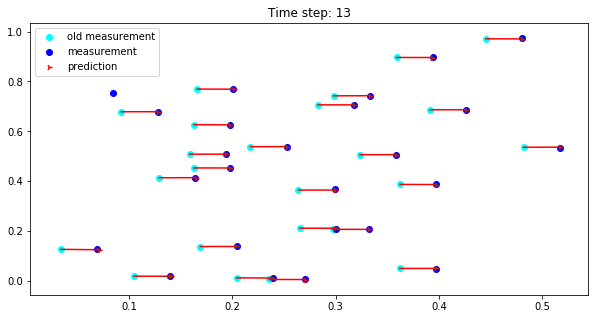

Distances
[[0.332 0.448 0.237 0.335 0.2   0.31  0.608 0.145 0.18  0.102 0.427 0.439
  0.612 0.277 0.622 0.485 0.001 0.116 0.609 0.17  0.146 0.214 0.088 0.513
  0.171 0.399 0.32 ]
 [0.583 0.835 0.586 0.722 0.427 0.424 0.485 0.525 0.563 0.358 0.331 0.362
  0.386 0.323 0.413 0.275 0.388 0.295 0.325 0.263 0.516 0.212 0.404 0.195
  0.464 0.02  0.107]
 [0.162 0.484 0.194 0.394 0.002 0.122 0.456 0.207 0.241 0.111 0.299 0.298
  0.504 0.149 0.505 0.396 0.202 0.165 0.532 0.169 0.31  0.215 0.29  0.475
  0.37  0.444 0.407]
 [0.264 0.491 0.228 0.386 0.111 0.208 0.509 0.181 0.221 0.001 0.331 0.34
  0.524 0.177 0.532 0.401 0.104 0.066 0.531 0.1   0.238 0.153 0.188 0.449
  0.273 0.373 0.318]
 [0.484 0.452 0.349 0.34  0.37  0.482 0.77  0.238 0.249 0.273 0.585 0.6
  0.756 0.443 0.77  0.626 0.171 0.269 0.737 0.32  0.117 0.35  0.087 0.627
  0.002 0.468 0.367]
 [0.374 0.644 0.38  0.537 0.216 0.235 0.43  0.333 0.373 0.155 0.243 0.264
  0.404 0.142 0.419 0.275 0.217 0.102 0.393 0.054 0.361 0.002 0.27  0.299


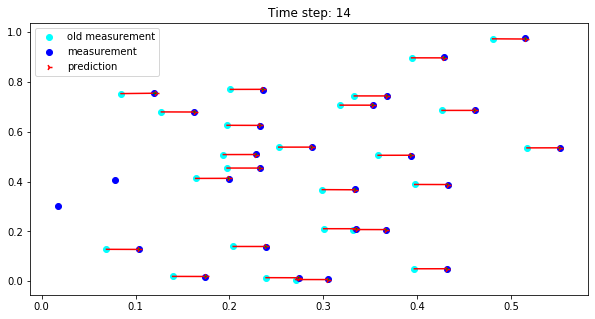

Distances
[[0.331 0.451 0.237 0.338 0.2   0.308 0.606 0.147 0.182 0.101 0.425 0.437
  0.61  0.273 0.62  0.485 0.002 0.113 0.607 0.17  0.147 0.214 0.09  0.511
  0.173 0.387 0.265 0.418 0.538 0.28  0.271]
 [0.583 0.836 0.586 0.723 0.426 0.424 0.486 0.525 0.563 0.358 0.331 0.363
  0.386 0.323 0.413 0.277 0.387 0.295 0.325 0.262 0.515 0.211 0.404 0.196
  0.462 0.002 0.12  0.055 0.155 0.251 0.307]
 [0.162 0.487 0.195 0.396 0.001 0.122 0.455 0.208 0.242 0.112 0.299 0.298
  0.504 0.147 0.504 0.397 0.201 0.165 0.532 0.169 0.309 0.215 0.291 0.474
  0.371 0.427 0.33  0.475 0.552 0.433 0.443]
 [0.264 0.493 0.229 0.387 0.111 0.208 0.508 0.182 0.222 0.001 0.33  0.34
  0.523 0.174 0.531 0.403 0.103 0.065 0.531 0.101 0.238 0.154 0.19  0.449
  0.274 0.359 0.247 0.4   0.5   0.325 0.332]
 [0.485 0.453 0.349 0.341 0.371 0.482 0.771 0.238 0.249 0.274 0.586 0.602
  0.757 0.441 0.771 0.629 0.172 0.269 0.738 0.322 0.117 0.352 0.086 0.627
  0.001 0.465 0.35  0.478 0.617 0.26  0.217]
 [0.663 0.961 0.696 0.851 

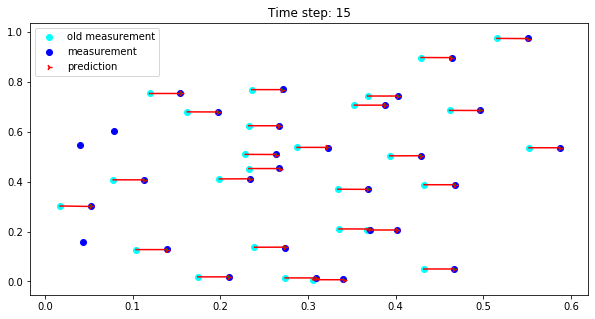

Distances
[[0.331 0.453 0.238 0.339 0.2   0.307 0.605 0.147 0.183 0.101 0.426 0.437
  0.609 0.271 0.618 0.486 0.001 0.112 0.607 0.168 0.148 0.213 0.09  0.51
  0.174 0.385 0.264 0.517 0.239 0.188 0.44  0.553 0.314]
 [0.583 0.836 0.586 0.723 0.425 0.424 0.486 0.524 0.563 0.357 0.332 0.363
  0.387 0.323 0.413 0.278 0.385 0.295 0.327 0.262 0.515 0.211 0.402 0.196
  0.462 0.001 0.12  0.148 0.245 0.304 0.09  0.17  0.259]
 [0.162 0.488 0.196 0.398 0.001 0.12  0.454 0.209 0.244 0.112 0.299 0.297
  0.502 0.145 0.501 0.397 0.201 0.165 0.532 0.168 0.311 0.214 0.291 0.473
  0.372 0.426 0.329 0.518 0.391 0.364 0.506 0.578 0.468]
 [0.264 0.494 0.229 0.387 0.111 0.208 0.508 0.182 0.223 0.    0.332 0.341
  0.523 0.173 0.529 0.404 0.102 0.065 0.532 0.1   0.238 0.154 0.189 0.448
  0.274 0.358 0.246 0.473 0.283 0.252 0.429 0.522 0.36 ]
 [0.485 0.453 0.349 0.341 0.372 0.483 0.771 0.238 0.249 0.275 0.588 0.602
  0.757 0.441 0.77  0.631 0.174 0.269 0.74  0.322 0.117 0.353 0.088 0.627
  0.001 0.464 0.35  0.6

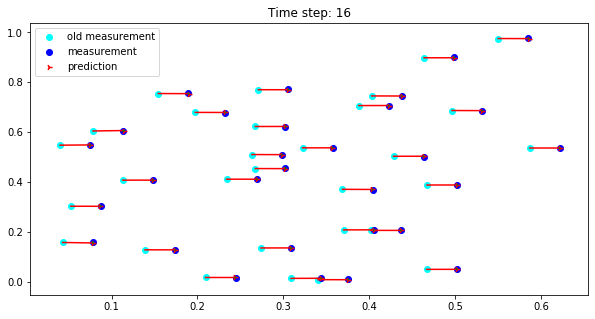

Distances
[[0.331 0.453 0.238 ... 0.34  0.341 0.464]
 [0.583 0.837 0.586 ... 0.347 0.367 0.648]
 [0.162 0.49  0.197 ... 0.516 0.522 0.665]
 ...
 [0.279 0.273 0.111 ... 0.49  0.485 0.513]
 [0.499 0.928 0.635 ... 0.788 0.804 1.038]
 [0.582 0.99  0.696 ... 0.744 0.762 1.018]]


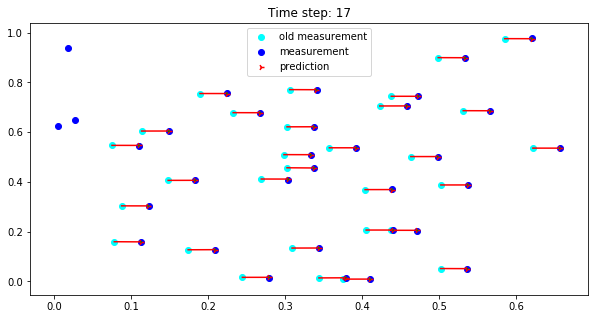

Distances
[[0.331 0.454 0.238 ... 0.376 0.491 0.49 ]
 [0.583 0.838 0.586 ... 0.381 0.656 0.654]
 [0.162 0.49  0.195 ... 0.556 0.691 0.691]
 ...
 [0.28  0.274 0.112 ... 0.52  0.546 0.545]
 [0.498 0.928 0.633 ... 0.828 1.057 1.056]
 [0.583 0.992 0.695 ... 0.782 1.034 1.032]]


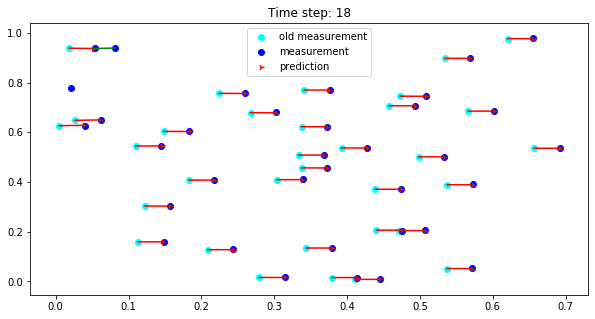

Distances
[[0.331 0.456 0.238 ... 0.439 0.411 0.519]
 [0.583 0.838 0.585 ... 0.512 0.397 0.664]
 [0.163 0.493 0.197 ... 0.634 0.59  0.72 ]
 ...
 [0.281 0.273 0.113 ... 0.546 0.554 0.578]
 [0.497 0.928 0.632 ... 0.946 0.852 1.074]
 [0.583 0.993 0.695 ... 0.908 0.803 1.049]]


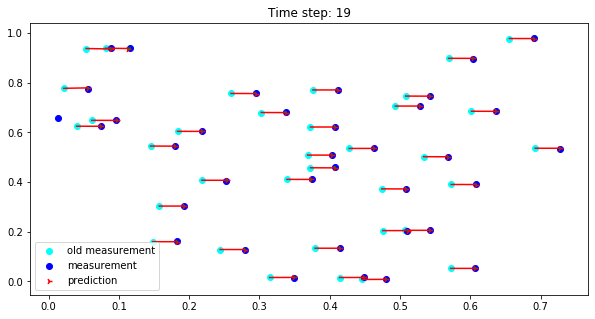

Distances
[[0.33  0.458 0.239 ... 0.473 0.695 0.503]
 [0.582 0.839 0.586 ... 0.527 0.318 0.244]
 [0.163 0.496 0.199 ... 0.667 0.734 0.616]
 ...
 [0.283 0.272 0.114 ... 0.581 0.883 0.686]
 [0.494 0.927 0.631 ... 0.968 0.645 0.724]
 [0.582 0.994 0.696 ... 0.928 0.524 0.641]]


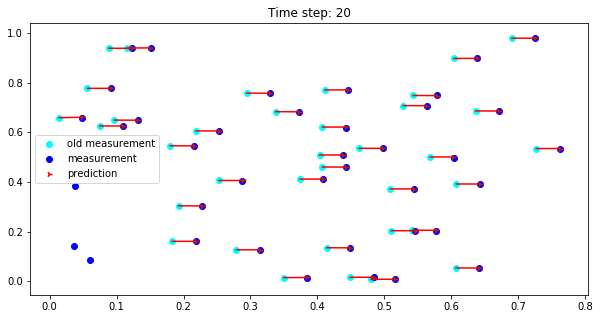

Distances
[[0.33  0.457 0.238 ... 0.483 0.719 0.533]
 [0.582 0.839 0.585 ... 0.451 0.344 0.278]
 [0.163 0.497 0.2   ... 0.663 0.763 0.65 ]
 ...
 [0.284 0.271 0.114 ... 0.621 0.908 0.715]
 [0.492 0.926 0.629 ... 0.915 0.68  0.756]
 [0.581 0.994 0.695 ... 0.862 0.558 0.671]]


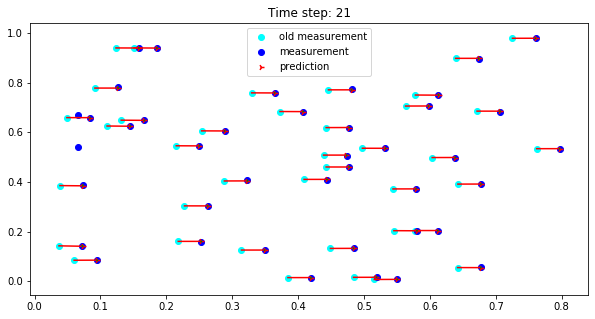

Distances
[[0.33  0.459 0.238 ... 0.417 0.413 0.516]
 [0.581 0.837 0.583 ... 0.307 0.414 0.456]
 [0.163 0.497 0.198 ... 0.573 0.596 0.693]
 ...
 [0.286 0.269 0.117 ... 0.586 0.551 0.659]
 [0.495 0.929 0.63  ... 0.781 0.867 0.93 ]
 [0.581 0.994 0.694 ... 0.721 0.821 0.87 ]]


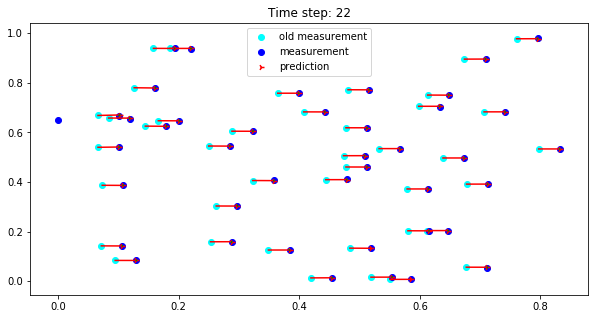

Distances
[[0.33  0.459 0.238 ... 0.551 0.588 0.773]
 [0.581 0.838 0.582 ... 0.478 0.619 0.407]
 [0.163 0.5   0.2   ... 0.727 0.785 0.826]
 ...
 [0.286 0.27  0.117 ... 0.694 0.689 0.965]
 [0.495 0.93  0.63  ... 0.957 1.077 0.75 ]
 [0.58  0.994 0.693 ... 0.893 1.029 0.627]]


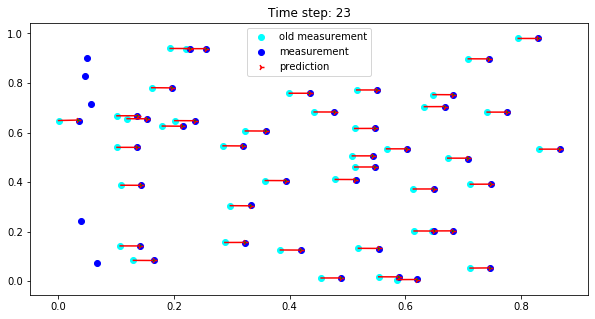

Distances
[[0.33  0.46  0.238 ... 0.593 0.586 0.622]
 [0.581 0.837 0.581 ... 0.552 0.503 0.638]
 [0.164 0.502 0.201 ... 0.778 0.762 0.817]
 ...
 [0.287 0.27  0.118 ... 0.721 0.728 0.724]
 [0.495 0.931 0.63  ... 1.027 0.984 1.102]
 [0.581 0.995 0.692 ... 0.967 0.917 1.051]]


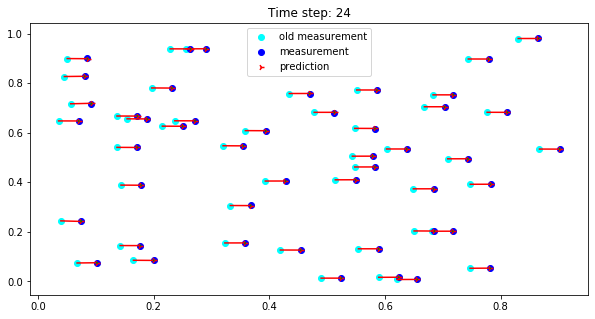

Distances
[[0.33  0.46  0.238 ... 0.816 0.648 0.722]
 [0.581 0.838 0.582 ... 0.46  0.644 0.793]
 [0.164 0.504 0.202 ... 0.879 0.842 0.925]
 ...
 [0.496 0.931 0.629 ... 0.82  1.112 1.242]
 [0.581 0.995 0.692 ... 0.697 1.057 1.199]
 [1.037 0.896 0.896 ... 0.9   0.181 0.007]]


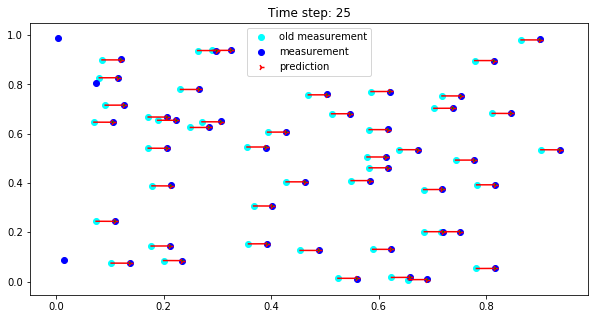

np.inf
Distances
[[   0.33     0.462    0.238 ...    0.718    0.842    0.752]
 [   0.582    0.84     0.582 ...    0.789    0.491    0.811]
 [   0.165    0.506    0.203 ...    0.921    0.91     0.955]
 ...
 [   0.582    0.997    0.692 ...    1.195    0.732    1.22 ]
 [   1.036    0.896    0.896 ...    0.004    0.9      0.041]
 [   0.03  9999.    9999.    ... 9999.    9999.    9999.   ]]


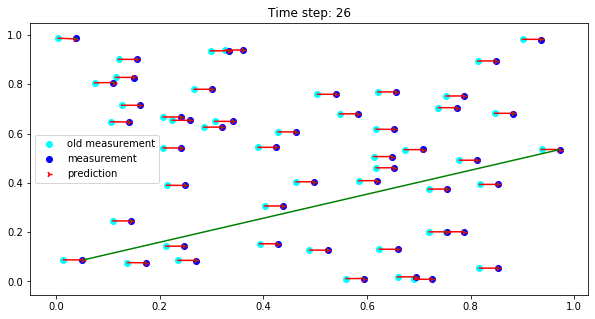

np.inf
Distances
[[   0.463    0.238    0.343 ...    0.692    0.695    0.784]
 [   0.84     0.581    0.72  ...    0.543    0.618    0.83 ]
 [   0.508    0.204    0.409 ...    0.855    0.877    0.986]
 ...
 [   0.996    0.69     0.896 ...    0.947    1.03     1.24 ]
 [   0.896    0.896    0.815 ...    0.425    0.296    0.076]
 [   0.032 9999.    9999.    ... 9999.    9999.    9999.   ]]


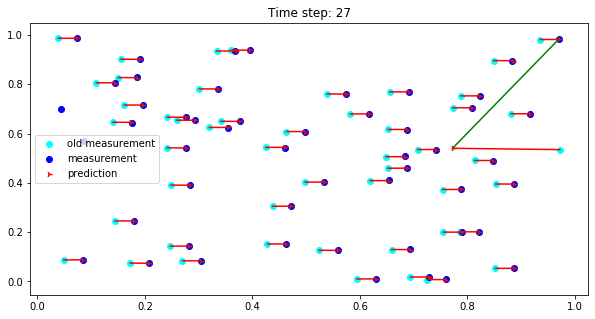

np.inf
Distances
[[   0.601    0.238    0.342 ...    0.802    0.649    0.73 ]
 [   0.466    0.58     0.718 ...    0.446    0.583    0.644]
 [   0.765    0.205    0.41  ...    0.862    0.832    0.911]
 ...
 [   0.876    0.69     0.895 ...    0.681    0.997    1.057]
 [   0.418    0.897    0.815 ...    0.901    0.287    0.308]
 [9999.       0.051 9999.    ... 9999.    9999.    9999.   ]]


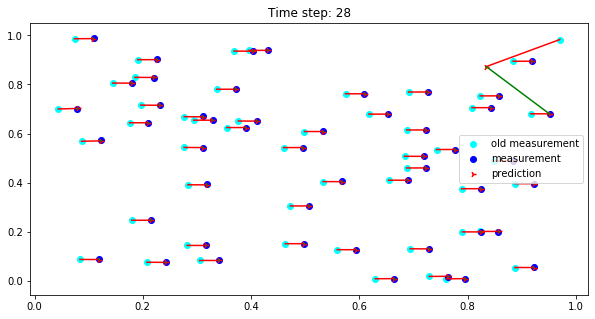

ValueError: ignored

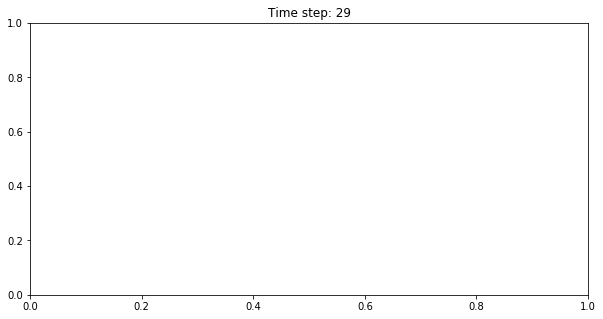

In [94]:
# create the model manager
model_manager = model.ModelManager(dataset_input.shape[0], batch_size, rnn_model)

TIME_STEPS = num_time_steps
MAX_NUM_TRAJECTORIES = dataset_input.shape[0]
SIZE_X = 1.
SIZE_Y = 1.
# the region, where the track is considered to appear / disappear
X_DETECTION_TOLERANCE = SIZE_X / 10.
X_DISAPPEAR_TOLERANCE = 0.05

# the distance of the pseudo measurements and tracks to the actual belt
X_THRESHOLD = 5./2000.

# generate increasing ids
def id_generator():
    n = 0
    while True:
        yield n
        n += 1

id_seed = id_generator()

all_ids = []

# mm: model_manager
# id => mm_id
id_2_mm = {}

# mm_id => id
mm_2_id = {}

# id => list(observations)
track_history = defaultdict(list)

active_ids = set()

for time_step in range(num_time_steps):
    plt.title('Time step: {}'.format(time_step))
    predictions_mm_ids = [id_2_mm[i] for i in sorted(active_ids)]
    predictions_ids = [i for i in sorted(active_ids)]
    predictions = model_manager.predict()
    
    predictions_mask = np.zeros(predictions.shape[0], dtype=np.bool)
    predictions_mask[predictions_mm_ids] = True
    
    predictions = predictions[predictions_mask]

    # old measurement
    old_observations = np.array(model_manager.batch_measurements).reshape([model_manager.n_batches * model_manager.batch_size, model_manager.num_dims])[predictions_mask]

    if measurements is not None:
      plt.scatter(measurements[:, 0], measurements[:, 1], c='cyan', label='old measurement')

      for pred_i in range(predictions.shape[0]):
        start = old_observations[pred_i]
        end = predictions[pred_i]
        line = np.stack((start, end), axis=0)
        plt.plot(line[:, 0], line[:, 1], c='red')
    
    
    measurements = dataset.get_measurement_at_timestep(time_step)
    mask = np.any(measurements != [nan_value, nan_value], axis=-1)
    measurements = measurements[mask]
    
    plt.scatter(measurements[:, 0], measurements[:, 1], c='blue', label='measurement')
    plt.scatter(predictions[:, 0], predictions[:, 1], marker='4', c='red', label='prediction')
    # plt.show()
    
    if measurements.shape[0] == 0:
        continue
    
    # 1. particle enters perception: add an artificial track for every measurement at the first 1/10 of the belt
    #   -> for every of these tracks: create an artificial measurement
    mask_new_tracks = measurements[:, 0] < X_DETECTION_TOLERANCE
    count_new_tracks = np.sum(mask_new_tracks)
    
    artificial_predictions = np.stack((np.ones(count_new_tracks)*-X_THRESHOLD,
                                        measurements[mask_new_tracks][:, 1]), axis=-1)
    
    # 2. particle leaves perception: the predicted particles which are in the terminal region of the belt
    mask_end_measurements = predictions[:, 0] > SIZE_X - X_DISAPPEAR_TOLERANCE
    count_end_measurements = np.sum(mask_end_measurements)
    artificial_measurements = np.stack((np.ones(count_end_measurements)*(SIZE_X + X_THRESHOLD),
                                        predictions[mask_end_measurements][:, 1]), axis=-1)
    
    # Distance matrix
    all_measurements = np.concatenate((measurements, artificial_measurements))
    all_predictions = np.concatenate((predictions, artificial_predictions))
    distances = distance_matrix(all_measurements, all_predictions)

    # ToDo: set the special distances for the artificial components
    #   (the artificial measurements and predictions are close together)
    # 1. artificial measurements (where tracks end) are only connected to the
    #    provocing track and one 
    distances[measurements.shape[0]:, :] = 9999
    for measurement_idx, prediction_idx in enumerate(np.where(mask_end_measurements)[0]):
      print('np.inf')
      distances[measurements.shape[0]+measurement_idx, prediction_idx] = np.abs(predictions[prediction_idx, 0] - (SIZE_X + X_THRESHOLD))

    with np.printoptions(precision=3, suppress=True):
      print("Distances")
      print(distances)
        
    measurement_assignment_ids, prediction_assignment_ids  = linear_sum_assignment(distances)
    
    # Different cases
    #    A | B
    #    -----
    #    C | D
    for measurement_id, prediction_id in zip(measurement_assignment_ids.tolist(), 
                                             prediction_assignment_ids.tolist()):
        # A) measurement <-> existing prediction   => add measurement as new observation of the track
        if measurement_id < measurements.shape[0] and prediction_id < predictions.shape[0]:
            id_ = predictions_ids[prediction_id]
            mm_track_id = id_2_mm[id_]
            model_manager.set_track_measurement(mm_track_id, all_measurements[measurement_id])
            # store observation
            track_history[id_].append([time_step, all_measurements[measurement_id]])

            line = np.stack((all_measurements[measurement_id], all_predictions[prediction_id]), axis=0)
            plt.plot(line[:, 0], line[:, 1], c='green')
            
            
        # B) artificial measurement <-> prediction  => delete track
        elif measurement_id >= measurements.shape[0] and prediction_id < predictions.shape[0]:
            id_ = predictions_ids[prediction_id]
            active_ids.remove(id_)
            mm_track_id = id_2_mm[id_]
            model_manager.free(mm_track_id)

            del mm_2_id[mm_track_id]
            del id_2_mm[id_]
            
        # C) measurement <-> artificial prediction  => create track     
        elif measurement_id < measurements.shape[0] and prediction_id >= predictions.shape[0]:
            # new global id
            id_ = next(id_seed)
            active_ids.add(id_)
            # new model manger id
            mm_track_id = model_manager.allocate_track()
            id_2_mm[id_] = mm_track_id
            mm_2_id[mm_track_id] = id_

            model_manager.set_track_measurement(mm_track_id, all_measurements[measurement_id])
            # store observation
            track_history[id_].append([time_step, all_measurements[measurement_id]])

        # D) artificial measurement <-> artificial prediction   => do nothing
        elif measurement_id >= measurements.shape[0] and prediction_id >= predictions.shape[0]:
            pass  

    plt.legend()
    plt.show()

    #if time_step == 3:
    #  break;  
    
    